## Regression of UK Exports Over Time

Given monthly data for UK exports to the rest of the world, we aim to build and test time series models with the aim of predicting the most recent 12 months of data (Mar 2024 - Feb 2025). This data is non-seasonally adjusted meaning we will compare how different models can predict trends but also model seasonality and noise simultaneously. 

We will first try a traditional time series approach using a Seasonal ARIMA model before comparing this with a flexible Bayesian approach in the form of a Gaussian Process Regression. We can choose between candidate models of each class using an information criterion (AIC, BIC or marginal likelihood) and compare between classes using metrics such as root mean squared error (RMSE) and log predictive scoring.

Data downloaded from the Office for National Statistics:
https://www.ons.gov.uk/economy/nationalaccounts/balanceofpayments/timeseries/lqad/mret

In [73]:
import pandas as pd
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [74]:
## READ DATA

df = pd.read_csv('series-230425 (1).csv') # Read ONS trade data
df = df.drop(list(range(0,147))).reset_index(drop=True) # Get rid of header & additional info and reset index.
df.rename(columns={df.columns[0]: 'date', df.columns[1]: 'exports'}, inplace=True) # Re-name columns for simplicity
df['exports'] = pd.to_numeric(df['exports'], errors='coerce')

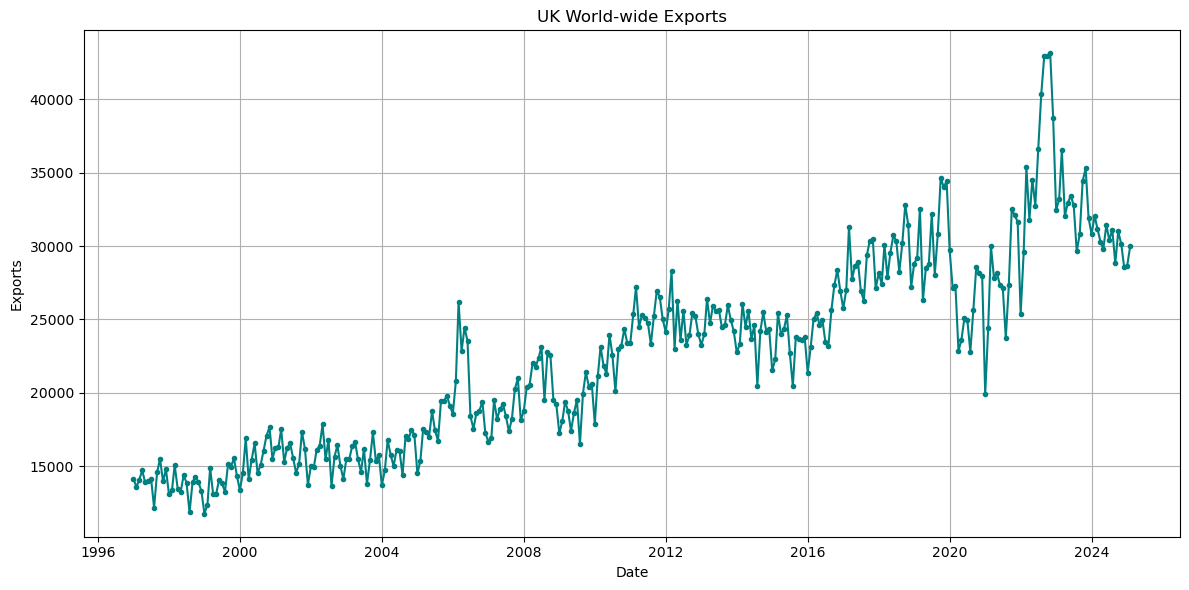

In [75]:
## PLOT EXPORTS

df['date'] = pd.to_datetime(df['date'], format='%Y %b') # Make 'date' column datetime type

plt.figure(figsize=(12, 6)) # Create plot
plt.plot(df['date'], df['exports'], marker='o', markersize=3,linestyle='-', color='teal')
plt.title('UK World-wide Exports')
plt.xlabel('Date')
plt.ylabel('Exports')
plt.grid(True)
plt.tight_layout()
plt.show()  

In [76]:
# Split data for training & testing
# Trained on historical data; Tested on past year (Mar 2024 - Feb 2025)

train_size = 326
test_size = 12

Y_train = df.iloc[:train_size, 1]  # First 326 points
Y_test = df.iloc[-test_size:, 1]  # Last 12 points
X_train = df.iloc[:train_size, 0]  # First 326 points
X_test = df.iloc[-test_size:, 0]  # Last 12 points

## S-ARIMA Approach:

Seasonal Auto-Regressive Integrated Moving Average (S-ARIMA) models are a common modelling technique for time series data. The model allows us to express future values in terms of past values as well as modelling trend, stochasticity and seasonality. 

As our exports data is monthly, we can most likely assume that our order of seasonality should be every 12 months.

The trend of our data also seems close to linear (a polynomial of order 1). This means that we can choose integration of order 1 for our model.

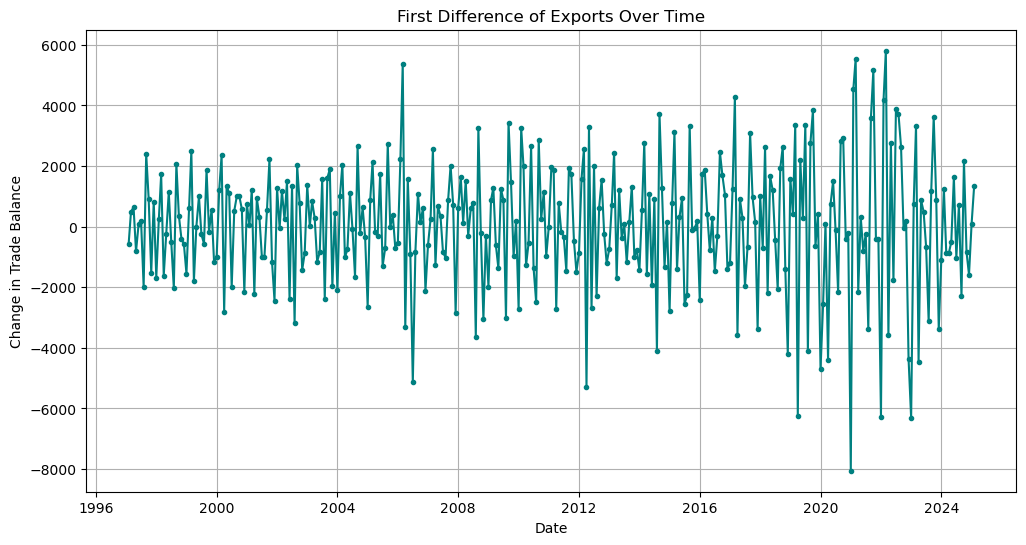

ADF Statistic: -5.74977981258532
p-value: 6.003841841406085e-07


In [77]:
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['exports'].diff(), marker='o', markersize =3, linestyle='-', color='teal')
plt.xlabel("Date")
plt.ylabel("Change in Trade Balance")
plt.title("First Difference of Exports Over Time")
plt.grid(True)
plt.show()

from statsmodels.tsa.stattools import adfuller

# Make sure the tradebalance column is numeric
df['exports'] = pd.to_numeric(df['exports'], errors='coerce')

# Take first difference & drop missing values (optional but useful before ADF)
diff_series = df['exports'].diff().dropna()

# Perform Augmented Dickey-Fuller test
result = adfuller(diff_series)

# Print the test results
print("ADF Statistic:", result[0])
print("p-value:", result[1])


After first-differencing, exports seem more stationary.

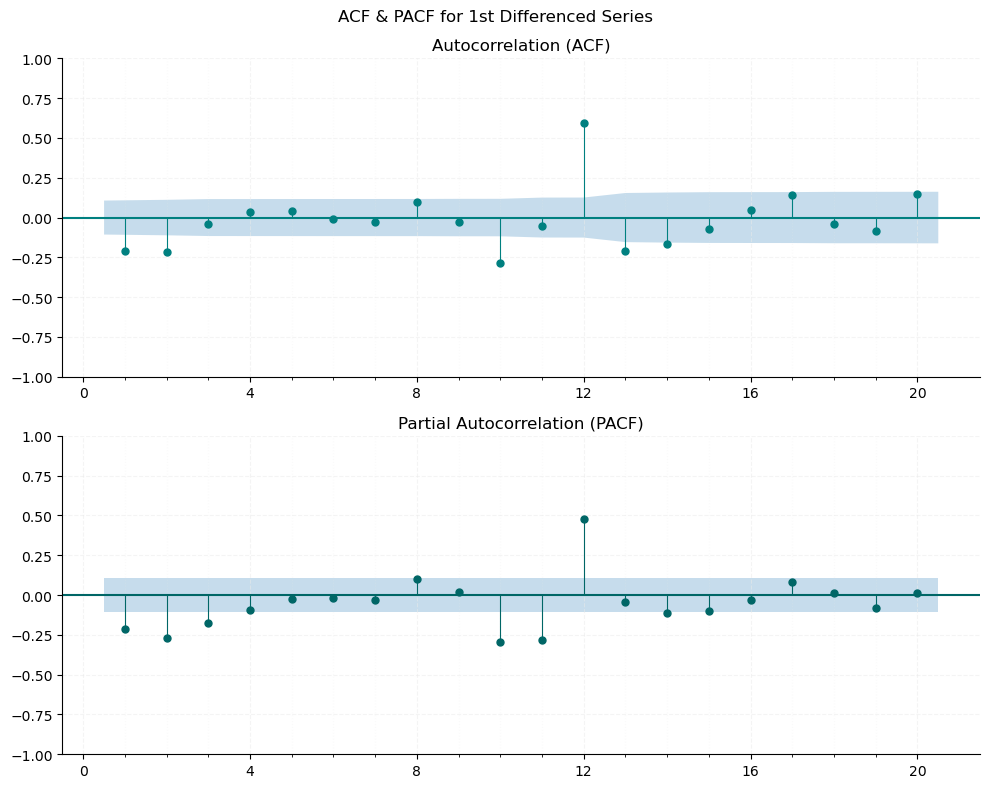

In [121]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Define teal color theme
TEAL = "#008080"
LIGHT_TEAL = "#4DB8B8"
DARK_TEAL = "#006666"


# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

plt.suptitle('ACF & PACF for 1st Differenced Series')
# Plot ACF (Teal-themed)
plot_acf(
    diff_series,
    lags=20,
    ax=ax1,
    color=TEAL,
    vlines_kwargs={"colors": TEAL, "linewidth": 0.8},
    title="Autocorrelation (ACF)",
    alpha=0.05,  # 95% confidence interval
    zero=False,  # Exclude lag 0 (trivial)
)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Plot PACF (Teal-themed)
plot_pacf(
    diff_series,
    lags=20,
    ax=ax2,
    color=DARK_TEAL,
    vlines_kwargs={"colors": DARK_TEAL, "linewidth": 0.8},
    title="Partial Autocorrelation (PACF)",
    method="ols",  # Regression-based PACF
    alpha=0.05,
    zero=False,
)
ax2.set_facecolor('white')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(True, linestyle='--', alpha=0.5)

for ax in [ax1, ax2]:
    ax.set_xticks(range(0, 21, 4), minor=False)  # Major ticks every 4
    ax.set_xticks(range(0, 21), minor=True)       # Minor ticks every lag
    ax.grid(which='minor', alpha=0.2, linestyle=':')
    
# Adjust layout and display
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

ACF and PACF plots show clear seasonality of 12 months and potentially a few lags of AR & MA components.

In [78]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

We can search for the best model form by checking many models and comparing their AIC.

In [79]:
# Automatic procedure: Checks each model form and selects model with lowest AIC.

import pmdarima as pm

automodel = pm.auto_arima(Y_train,
                      seasonal=True,
                      m=12,
                      d=1,
                      D=1,
                      max_P=2, max_Q=2,
                      trace=True,
                      max_iter=500,
                      disp=False)
print(automodel.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=5494.735, Time=1.44 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5598.851, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5561.978, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5495.604, Time=0.32 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=5497.969, Time=1.17 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(2,1,2)(2,1,1)[12]             : AIC=inf, Time=2.69 sec
 ARIMA(2,1,2)(1,1,2)[12]             : AIC=inf, Time=3.71 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=inf, Time=0.84 sec
 ARIMA(2,1,2)(0,1,2)[12]             : AIC=inf, Time=2.69 sec
 ARIMA(2,1,2)(2,1,0)[12]             : AIC=5523.443, Time=2.39 sec
 ARIMA(2,1,2)(2,1,2)[12]             : AIC=5501.485, Time=3.25 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=inf, Time=1.18 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=inf, Time=1.21 sec
 ARIMA(3,1,2)(1,1,1)[12]             : AIC=inf, Time=1

The 'best' model was SARIMAX(0,1,1)x(2,1,2)[12]. It is not intuitive why we do not have any AR component and upon looking at the output, the model with AR part included was disqualified because the MLE optimisation did not converge. We can try that model again and see if it does any better:

In [ ]:
model_sarima = SARIMAX(
    Y_train,
    order=(1,1,1),
    seasonal_order=(2,1,2,12)
).fit(maxiter=500, disp=False) # Change optimisation configurations to help it converge
print(model_sarima.aic)

print(model_sarima.mle_retvals) # The MLEs converged
model_sarima.summary()

5455.157891421999
{'fopt': 8.345334189297544, 'gopt': array([-2.44462228e-06,  7.46069874e-09,  2.91771940e-05,  1.33280054e-05,
       -6.78177514e-06,  1.03707265e-05,  3.58824082e-08]), 'fcalls': 496, 'warnflag': 0, 'converged': True, 'iterations': 53}


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                 exports   No. Observations:                  326
Model:             SARIMAX(1, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood               -2720.579
Date:                                 Thu, 01 May 2025   AIC                           5455.158
Time:                                         14:11:35   BIC                           5481.381
Sample:                                              0   HQIC                          5465.637
                                                 - 326                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8378      0.025     33.971      0.000       0.789       0.886
ma.L1         -1.0000      0.055    -18.153      0.000      -1.108      -0.892
ar.S.L12       0.9158      0.122      7.501      0.000       0.676       1.155
ar.S.L24      -0.4633      0.051     -9.036      0.000      -0.564      -0.363
ma.S.L12      -1.5716      0.127    -12.366      0.000      -1.821      -1.323
ma.S.L24       0.7077      0.118      6.010      0.000       0.477       0.939
sigma2      1.912e+06   2.88e-08   6.64e+13      0.000    1.91e+06    1.91e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.68   Jarque-Bera (JB):               112.52
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               2.95   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.17e+29. Standard errors may be unstable.
"""

The model with the AR(1) component converged this time and the AIC score is 10 better which is fairly substantial.

This has a few problems as residuals seem serially correlated. Also, the Jarque-Bera test for normality has a small p-value indicating normal errors are a poor assumption here.

(4807.553572958769, 0.0, 1.0714095973847177, 21.690603261749747)


Text(0, 0.5, 'Value')

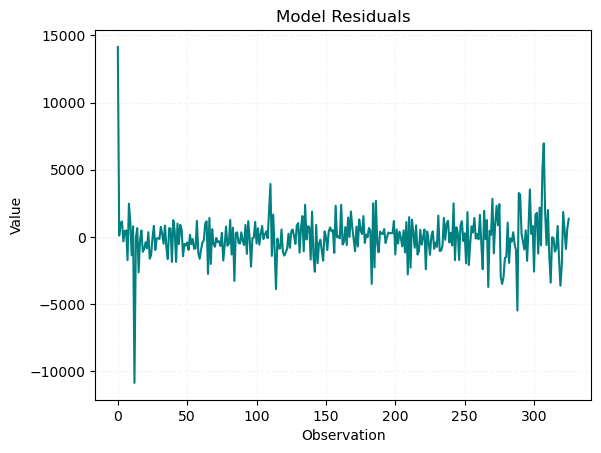

In [116]:
residuals = model_sarima.resid

# Perform the Jarque-Bera test
jb_test = sm.stats.stattools.jarque_bera(residuals)

# Print the results
print(jb_test)

plt.plot(residuals, linestyle='-', color='teal')
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Model Residuals')
plt.xlabel('Observation')
plt.ylabel('Value')

In [129]:
# Log-scoring rule to assess the predicted standard errors
def log_score(y_true, y_pred_mean, y_pred_std): 
    var = y_pred_std**2
    return -0.5 * np.log(2 * np.pi * var) - 0.5 * ((y_true - y_pred_mean)**2 / var)

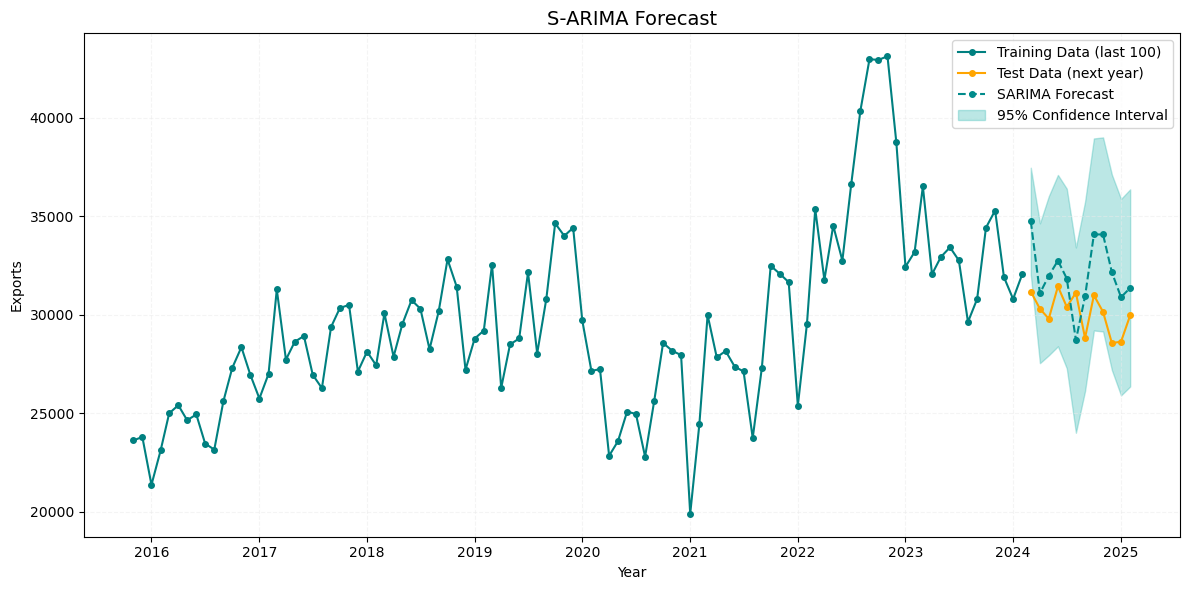

AIC: 5455.157891421999
Root Mean-squared Error: 2533.201315200346
Average Log Predictive Score (LPS): -9.363255635944208


In [165]:
import matplotlib.pyplot as plt

# Extract last 100 training dates and values
n_last = 100
X_train_last50 = X_train[-n_last:]
Y_train_last50 = Y_train[-n_last:]

# Forecast
forecast_object = model_sarima.get_forecast(steps=12)
forecast_mean = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(X_train_last50, Y_train_last50, color='teal',marker='o', markersize=4, label='Training Data (last 100)')
plt.plot(X_test, Y_test, 'o-', color='Orange',markersize=4, label='Test Data (next year)')
plt.plot(X_test, forecast_mean, 'o--',markersize=4, color='darkcyan', label='SARIMA Forecast')
plt.fill_between(X_test,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='lightseagreen',
                 alpha=0.3,
                 label='95% Confidence Interval')

# Formatting
plt.title('S-ARIMA Forecast', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Exports')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#AIC
print('AIC:',model_sarima.aic)

# RMSE
rmse = (np.mean((Y_test-forecast_mean)**2))**0.5
print('Root Mean-squared Error:', rmse)

# Log Score
y_std = (conf_int.iloc[:, 1] - conf_int.iloc[:, 0]) / (2 * 1.96) # SEs from the CI width
log_scores = log_score(Y_test, forecast_mean, y_std)
average_log_score = np.mean(log_scores)
print("Average Log Predictive Score (LPS):", average_log_score)

Although some predictions are far off due to amplitude of noise being exaggerated by the S-ARIMA model, seasonality seems well captured.

{'fopt': 9.071516453424728, 'gopt': array([-6.14104323e-06,  6.81232834e-07]), 'fcalls': 15, 'warnflag': 0, 'converged': True, 'iterations': 2}


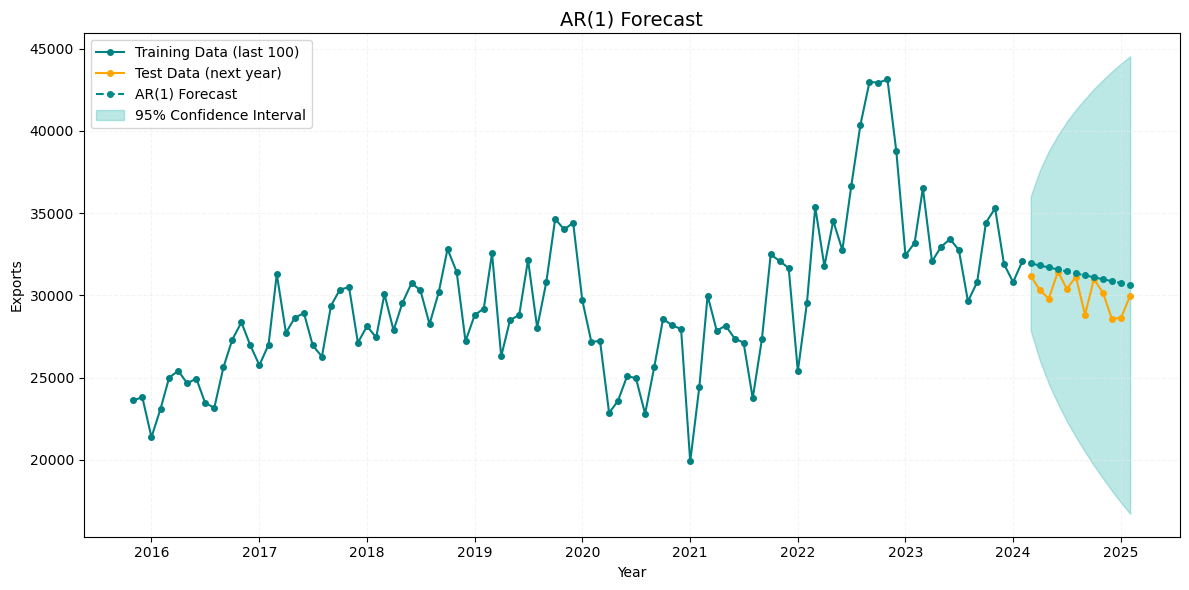

AIC: 5918.628727632922
Root Mean-squared Error: 1419.433136896925
Average Log Predictive Score (LPS): -9.435479166391774


In [164]:
# Simplistic AR(1) for comparison.
model_ar1 = SARIMAX(
    Y_train,
    order=(1,0,0),
    seasonal_order=(0,0,0,0)
).fit(maxiter=500, disp=False) # Change optimisation configurations to help it converge

print(model_ar1.mle_retvals) # The MLEs converged
model_ar1.summary()

# Extract last 100 training dates and values
n_last = 100
X_train_last50 = X_train[-n_last:]
Y_train_last50 = Y_train[-n_last:]

# Forecast
forecast_object = model_ar1.get_forecast(steps=12)
forecast_mean = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(X_train_last50, Y_train_last50, color='teal',marker='o', markersize=4, label='Training Data (last 100)')
plt.plot(X_test, Y_test, 'o-', color='Orange',markersize=4, label='Test Data (next year)')
plt.plot(X_test, forecast_mean, 'o--',markersize=4, color='darkcyan', label='AR(1) Forecast')
plt.fill_between(X_test,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='lightseagreen',
                 alpha=0.3,
                 label='95% Confidence Interval')

# Formatting
plt.title('AR(1) Forecast', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Exports')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#AIC
print('AIC:',model_ar1.aic)

# RMSE
rmse = (np.mean((Y_test-forecast_mean)**2))**0.5
print('Root Mean-squared Error:', rmse)

# Log Score
y_std = (conf_int.iloc[:, 1] - conf_int.iloc[:, 0]) / (2 * 1.96) # SEs from the CI width
log_scores = log_score(Y_test, forecast_mean, y_std)
average_log_score = np.mean(log_scores)
print("Average Log Predictive Score (LPS):", average_log_score)

For comparison, AR(1) model predicts well however AIC score is much worse. This suggests that the predictions of a simpler model may be hurt in any time of higher volatility.

## Gaussian Process Regression Approach

Gaussian Process Regression is a flexible Bayesian approach to prediction where let the function that our target variable follows remain general but impose the assumption that our uncertainty is Gaussian. 

In [141]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, 
                                              ExpSineSquared, DotProduct, 
                                              ConstantKernel, WhiteKernel)
X_train_numeric = np.array(list(range(0,326))).reshape(-1, 1)
X_test_numeric = np.array(list(range(326,338))).reshape(-1, 1)

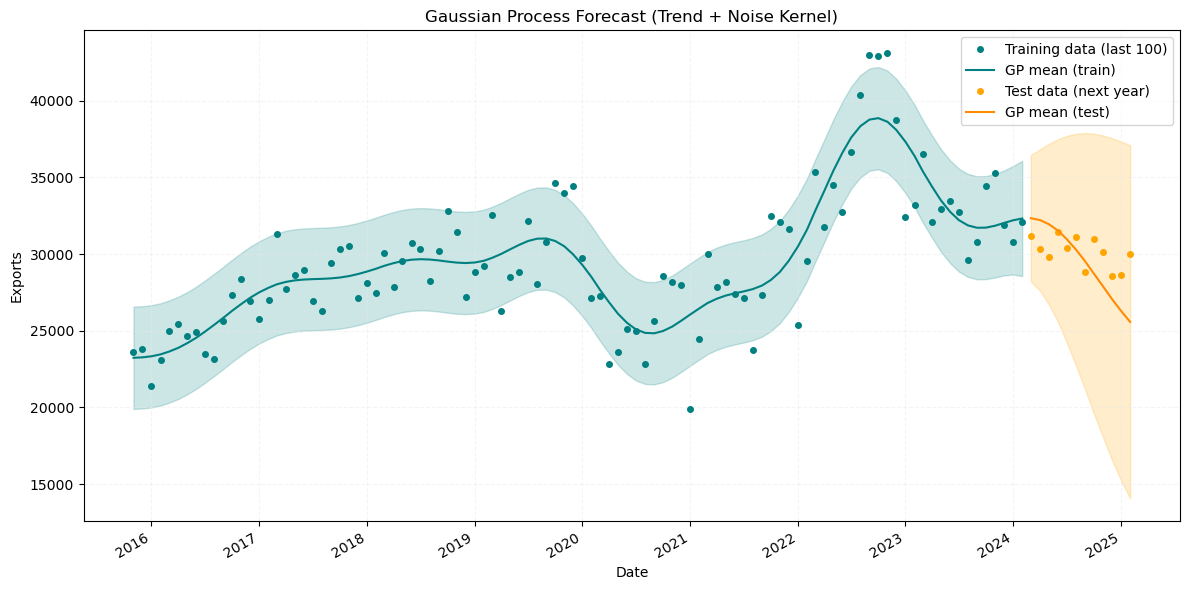

Evidence: -106.4841672479725
Root Mean-squared Error: 2007.7716788603207
Average Log Predictive Score (LPS): -9.286981617454815
Optimized kernel: RBF(length_scale=8.72) + WhiteKernel(noise_level=0.0604)


In [163]:
kernel =(RBF(length_scale=1.0, length_scale_bounds=(5,30)) # Trend kernel
         +WhiteKernel() ) # Noise

# Fit GP with hyperparameter optimization
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-2, n_restarts_optimizer=10, normalize_y=True)
gpr.fit(X_train_numeric, Y_train)

# Select last 100 training points
n_last = 100
X_train_last = X_train[-n_last:]
Y_train_last = Y_train[-n_last:]
X_train_numeric_scaled_last = X_train_numeric[-n_last:]

# Predict
y_pred_train, y_std_train = gpr.predict(X_train_numeric_scaled_last, return_std=True)
y_pred_test, y_std_test = gpr.predict(X_test_numeric, return_std=True)

# Confidence intervals
y_lower_train = y_pred_train - 1.96 * y_std_train
y_upper_train = y_pred_train + 1.96 * y_std_train
y_lower_test = y_pred_test - 1.96 * y_std_test
y_upper_test = y_pred_test + 1.96 * y_std_test

# Plot
plt.figure(figsize=(12, 6))
plt.plot(X_train_last, Y_train_last, 'o', label='Training data (last 100)', markersize=4, color='teal')
plt.fill_between(X_train_last, y_lower_train, y_upper_train, color='teal', alpha=0.2)
plt.plot(X_train_last, y_pred_train, '-', color='teal', label='GP mean (train)')

plt.plot(X_test, Y_test, 'o', label='Test data (next year)', markersize=4, color='orange')
plt.plot(X_test, y_pred_test, '-', color='darkorange', label='GP mean (test)')
plt.fill_between(X_test, y_lower_test, y_upper_test, color='orange', alpha=0.2)

plt.title('Gaussian Process Forecast (Trend + Noise Kernel)')
plt.xlabel('Date')
plt.ylabel('Exports')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

# Model Evidence
loglik= gpr.log_marginal_likelihood_value_
print('Evidence:', loglik)

# RMSE
rmse = (np.mean((Y_test-y_pred_test)**2))**0.5
print('Root Mean-squared Error:', rmse)

# Log Score
log_scores = log_score(Y_test, y_pred_test, y_std_test)
average_log_score = np.mean(log_scores)
print("Average Log Predictive Score (LPS):", average_log_score)
# After fitting the model
print("Optimized kernel:", gpr.kernel_)

The simplistic kernel cannot describe the seasonality and long term trend and just reverts to the sample mean in the predictions. 

Next we will try a more complex kernel that models trend, seasonality and noise:

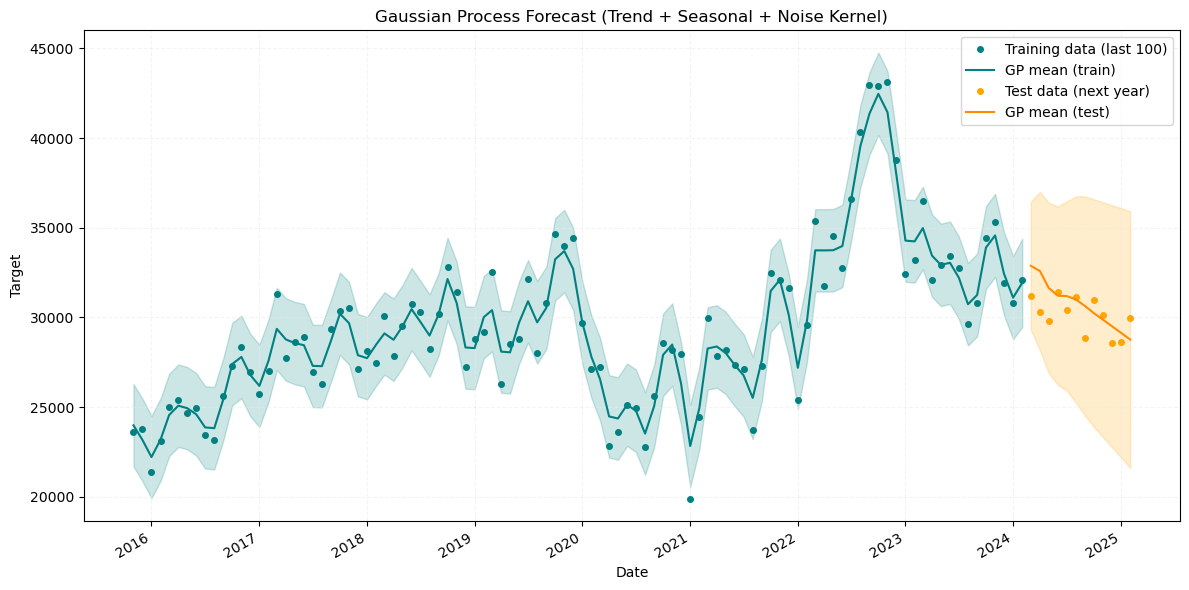

Evidence: -70.14105499268328
Root Mean-squared Error: 1246.4470566567188
Average Log Predictive Score (LPS): -9.009390334367977
Optimized kernel: 0.865**2 * RBF(length_scale=25.3) + 0.32**2 * RBF(length_scale=3.63) * ExpSineSquared(length_scale=1.63, periodicity=5.28) + 0.367**2 * WhiteKernel(noise_level=0.135)


In [160]:
kernel = (1**2 * RBF(length_scale=15, length_scale_bounds= (3,30)) # Long term trend
          + 1**2 * RBF(length_scale=1) * ExpSineSquared(length_scale=1, periodicity=12, periodicity_bounds=(4,8)) # Periodic Part
          + 1**2 * WhiteKernel(noise_level=1) # Noise Part
        )

# Fit GP with hyperparameter optimization
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-2, n_restarts_optimizer=10, normalize_y=True, random_state=13)
gpr.fit(X_train_numeric, Y_train)

# Select last 100 training points
n_last = 100
X_train_last = X_train[-n_last:]
Y_train_last = Y_train[-n_last:]
X_train_numeric_scaled_last = X_train_numeric[-n_last:]

# Predict
y_pred_train, y_std_train = gpr.predict(X_train_numeric_scaled_last, return_std=True)
y_pred_test, y_std_test = gpr.predict(X_test_numeric, return_std=True)

# Confidence intervals
y_lower_train = y_pred_train - 1.96 * y_std_train
y_upper_train = y_pred_train + 1.96 * y_std_train
y_lower_test = y_pred_test - 1.96 * y_std_test
y_upper_test = y_pred_test + 1.96 * y_std_test

# Plot
plt.figure(figsize=(12, 6))
plt.plot(X_train_last, Y_train_last, 'o', label='Training data (last 100)', markersize=4, color='teal')
plt.fill_between(X_train_last, y_lower_train, y_upper_train, color='teal', alpha=0.2)
plt.plot(X_train_last, y_pred_train, '-', color='teal', label='GP mean (train)')

plt.plot(X_test, Y_test, 'o', label='Test data (next year)', markersize=4, color='orange')
plt.plot(X_test, y_pred_test, '-', color='darkorange', label='GP mean (test)')
plt.fill_between(X_test, y_lower_test, y_upper_test, color='orange', alpha=0.2)

plt.title('Gaussian Process Forecast (Trend + Seasonal + Noise Kernel)')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

# Model Evidence
loglik= gpr.log_marginal_likelihood_value_
print('Evidence:', loglik)

# RMSE
rmse = (np.mean((Y_test-y_pred_test)**2))**0.5
print('Root Mean-squared Error:', rmse)

# Log Score
log_scores = log_score(Y_test, y_pred_test, y_std_test)
average_log_score = np.mean(log_scores)
print("Average Log Predictive Score (LPS):", average_log_score)

# Parameter values
print("Optimized kernel:", gpr.kernel_)

This model boasts a strong evidence score (higher is better) and seems to catch periodicity in the training data better. However, this does not extend to predictions where it has not been able to capture any of the periodic nature of the data.

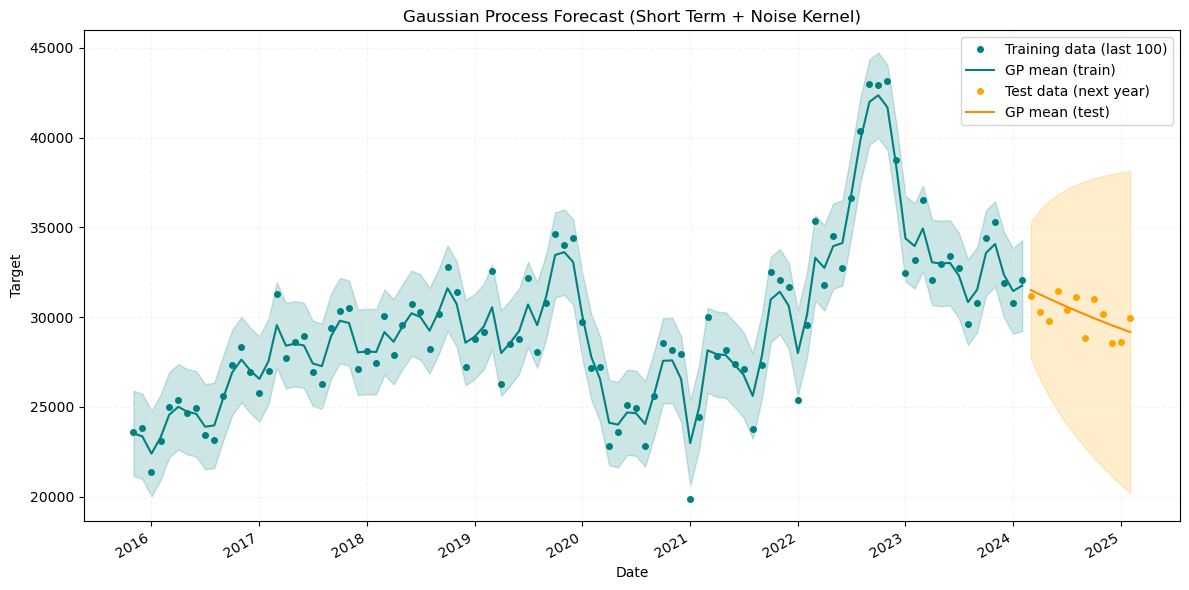

Evidence: -80.58653770368349
Root Mean-squared Error: 851.0079940426691
Average Log Predictive Score (LPS): -9.088848459240763
Optimized kernel: Matern(length_scale=38, nu=0.5) + WhiteKernel(noise_level=0.0189)


In [161]:
kernel =(Matern(length_scale=1.0, length_scale_bounds=(0.1,38), nu=0.5) # Short term kernel
         + WhiteKernel()) # Noise

# Fit GP with hyperparameter optimization
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-2, n_restarts_optimizer=10, normalize_y=True)
gpr.fit(X_train_numeric, Y_train)

# Select last 50 training points
n_last = 100
X_train_last = X_train[-n_last:]
Y_train_last = Y_train[-n_last:]
X_train_numeric_scaled_last = X_train_numeric[-n_last:]

# Predict
y_pred_train, y_std_train = gpr.predict(X_train_numeric_scaled_last, return_std=True)
y_pred_test, y_std_test = gpr.predict(X_test_numeric, return_std=True)

# Confidence intervals
y_lower_train = y_pred_train - 1.96 * y_std_train
y_upper_train = y_pred_train + 1.96 * y_std_train
y_lower_test = y_pred_test - 1.96 * y_std_test
y_upper_test = y_pred_test + 1.96 * y_std_test

# Plot
plt.figure(figsize=(12, 6))
plt.plot(X_train_last, Y_train_last, 'o', label='Training data (last 100)', markersize=4, color='teal')
plt.fill_between(X_train_last, y_lower_train, y_upper_train, color='teal', alpha=0.2)
plt.plot(X_train_last, y_pred_train, '-', color='teal', label='GP mean (train)')

plt.plot(X_test, Y_test, 'o', label='Test data (next year)', markersize=4, color='orange')
plt.plot(X_test, y_pred_test, '-', color='darkorange', label='GP mean (test)')
plt.fill_between(X_test, y_lower_test, y_upper_test, color='orange', alpha=0.2)

plt.title('Gaussian Process Forecast (Short Term + Noise Kernel)')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

# Model Evidence
loglik= gpr.log_marginal_likelihood_value_
print('Evidence:', loglik)

# RMSE
rmse = (np.mean((Y_test-y_pred_test)**2))**0.5
print('Root Mean-squared Error:', rmse)

# Log Score
log_scores = log_score(Y_test, y_pred_test, y_std_test)
average_log_score = np.mean(log_scores)
print("Average Log Predictive Score (LPS):", average_log_score)

# After fitting the model
print("Optimized kernel:", gpr.kernel_)

This model has good predictions and a strong log predictive score but fails to model seasonality. 

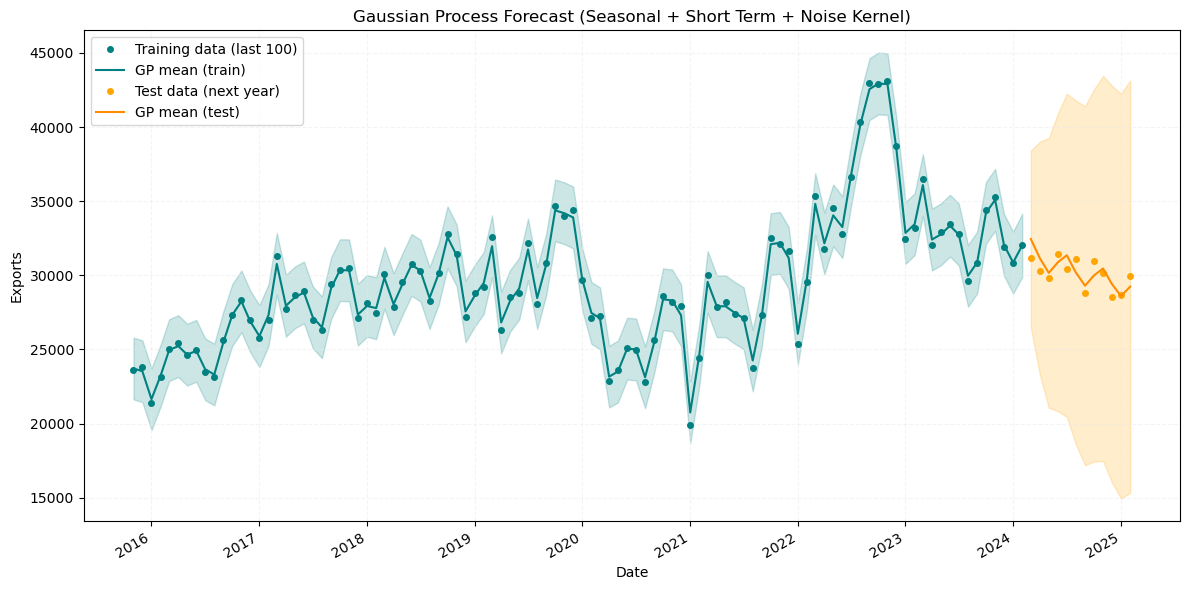

Evidence: -121.61076104764547
Root Mean-squared Error: 769.2438802233496
Average Log Predictive Score (LPS): -9.554270425122438
Optimized kernel: RBF(length_scale=40) * ExpSineSquared(length_scale=10, periodicity=4.02) + Matern(length_scale=10, nu=0.5) + WhiteKernel(noise_level=0.01)


In [168]:
kernel =(RBF(length_scale=(30), length_scale_bounds=(5,40)) * ExpSineSquared(periodicity=6, periodicity_bounds=(4,10), length_scale_bounds=(0.1,10)) # Seasonal part
         +Matern(length_scale=1.0, length_scale_bounds=(0.1,10), nu=0.5)
         +WhiteKernel(noise_level_bounds=(0.01,1))) # Short term kernel

# Fit GP with hyperparameter optimization
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-2, n_restarts_optimizer=10, normalize_y=True)
gpr.fit(X_train_numeric, Y_train)

# Select last 50 training points
n_last = 100
X_train_last = X_train[-n_last:]
Y_train_last = Y_train[-n_last:]
X_train_numeric_scaled_last = X_train_numeric[-n_last:]

# Predict
y_pred_train, y_std_train = gpr.predict(X_train_numeric_scaled_last, return_std=True)
y_pred_test, y_std_test = gpr.predict(X_test_numeric, return_std=True)

# Confidence intervals
y_lower_train = y_pred_train - 1.96 * y_std_train
y_upper_train = y_pred_train + 1.96 * y_std_train
y_lower_test = y_pred_test - 1.96 * y_std_test
y_upper_test = y_pred_test + 1.96 * y_std_test

# Plot
plt.figure(figsize=(12, 6))
plt.plot(X_train_last, Y_train_last, 'o', label='Training data (last 100)', markersize=4, color='teal')
plt.fill_between(X_train_last, y_lower_train, y_upper_train, color='teal', alpha=0.2)
plt.plot(X_train_last, y_pred_train, '-', color='teal', label='GP mean (train)')

plt.plot(X_test, Y_test, 'o', label='Test data (next year)', markersize=4, color='orange')
plt.plot(X_test, y_pred_test, '-', color='darkorange', label='GP mean (test)')
plt.fill_between(X_test, y_lower_test, y_upper_test, color='orange', alpha=0.2)

plt.title('Gaussian Process Forecast (Seasonal + Short Term + Noise Kernel)')
plt.xlabel('Date')
plt.ylabel('Exports')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

# Model Evidence
loglik= gpr.log_marginal_likelihood_value_
print('Evidence:', loglik)

# RMSE
rmse = (np.mean((Y_test-y_pred_test)**2))**0.5
print('Root Mean-squared Error:', rmse)

# Log Score
log_scores = log_score(Y_test, y_pred_test, y_std_test)
average_log_score = np.mean(log_scores)
print("Average Log Predictive Score (LPS):", average_log_score)

# After fitting the model
print("Optimized kernel:", gpr.kernel_)

This model has the best root mean squared error but has a poor log predictive score due to standard errors being too large.

## Conclusion:

Generally, the flexibility that GPs offer seem to give them the edge over traditional time series models such as the S-ARIMA model. While the seasonal + short term + noise kernel produced the lowest RMSE, its poor log-score leaves it a touch behind the trend + seasonal + noise and short term + noise GPs.

The short term + noise GP is actually nearly analagous to an AR(1) model but modelled in continuous time and optimised from a Bayesian perspective. This is because the exponential kernel is equivalent to an AR(1) likelihood with Normal errors. This highlights the strong impact that interpretation and philosophy can have on results even when two models are very similar in structure.

In [173]:
results = {
    'S-ARIMA': {'RMSE': 2533, 'Log Score': -9.363},
    'AR(1)': {'RMSE': 1419, 'Log Score': -9.435},
    'Trend + Noise GP': {'RMSE': 2007, 'Log Score': -9.286},
    'Trend + Seasonal + Noise GP': {'RMSE': 1246, 'Log Score': -9.009},
    'Short Term + Noise GP': {'RMSE': 851, 'Log Score': -9.088},
    'Seasonal + Short Term + Noise GP': {'RMSE': 769, 'Log Score': -9.554},
}

# Create DataFrame
df = pd.DataFrame(results)

# Display table
df

,S-ARIMA,AR(1),Trend + Noise GP,Trend + Seasonal + Noise GP,Short Term + Noise GP,Seasonal + Short Term + Noise GP
RMSE,2533.000,1419.000,2007.000,1246.000,851.000,769.000
Log Score,-9.363,-9.435,-9.286,-9.009,-9.088,-9.554
